In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import ast
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
sns.set()

from pyathena import connect

In [10]:
conn = connect(s3_staging_dir='s3://aws-athena-query-results-415718651610-us-east-1', region_name='us-east-1')
df = pd.read_sql("SELECT * FROM das.ocorrencias limit 50000", conn)

In [11]:
df.describe()

,duracao_s
count,28546.000000
mean,5971.369194
std,26704.919253
min,0.000000
25%,120.000000
50%,300.000000
75%,900.000000
max,607500.000000


In [12]:
df.head()

,nome,host,abertura,fechamento,duracao_s
0,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900
1,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900
2,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900
3,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900
4,Utilização de Download no link INTEGRA_VIVO ac...,INT-poa-fw,2019-03-29 16:05:05,2019-03-29 16:06:04,59


In [13]:
df.dropna(inplace=True)

In [14]:
table = pd.DataFrame(df)

In [15]:
np.unique(table.nome.values)

array(['% used CPU is overloaded : 80.77 % (warn)',
       '% used CPU is overloaded : 82.51 % (warn)',
       '% used CPU is overloaded : 82.64 % (warn)', ...,
       'salt-minion não está executando',
       'sv-ca-spy has just been restarted',
       '{$TIPO3}: PAY-spo-imaxis-vpn inacessível a partir do servidor PAY-smcd60csrv15'],
      dtype=object)

In [16]:
lbe = LabelEncoder()
table['name_encoded'] = lbe.fit_transform(table.nome.values)

In [17]:
table.head()

,nome,host,abertura,fechamento,duracao_s,name_encoded
0,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900,787
1,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900,787
2,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900,787
3,Chove em João Pessoa Joao Pessoa,Joao Pessoa,2019-03-26 14:43:59,2019-03-26 14:58:59,900,787
4,Utilização de Download no link INTEGRA_VIVO ac...,INT-poa-fw,2019-03-29 16:05:05,2019-03-29 16:06:04,59,5283


### Forma da distribuição da duração dos problemas

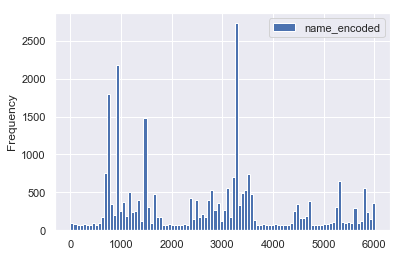

In [18]:
table[['nome','name_encoded']].plot.hist(bins=100)

In [19]:
print(f'Há um total de {len(np.unique(table.name_encoded.values))} occorências nesta amostra')

Há um total de 6014 occorências nesta amostra


### Duracação médias dos problemas (início até serem resolvidos)

A grande maioria é resolvido entre 0 e 25000 segundos. Há alguns pontos fora da normalidade que demoram mais para serem resolvidos como pode ser visto principalmente no boxplot.

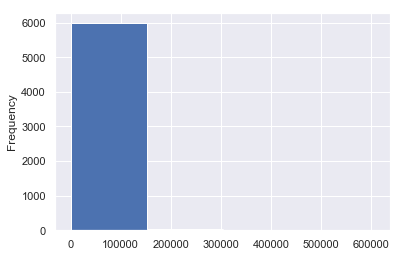

In [20]:
table.groupby('name_encoded').duracao_s.mean().plot.hist(bins=4)

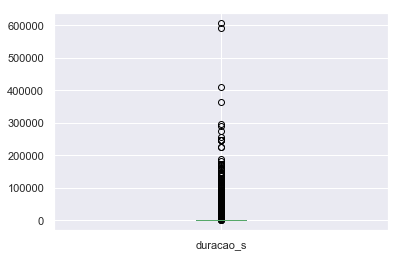

In [21]:
table.groupby('name_encoded').duracao_s.mean().plot.box()

## Análise da duração do problema que mais ocorre

In [22]:
key_value = dict(table.groupby('name_encoded').name_encoded.count())

In [23]:
greater_problem = max(key_value, key=key_value.get)

In [24]:
print(f'O problema que mais ocorre é o {table[table["name_encoded"]==greater_problem]["nome"].iloc[0]}')

O problema que mais ocorre é o CPU acima de 90


In [25]:
sub_table =table[table['name_encoded']==greater_problem]

In [26]:
sub_table[['duracao_s']].describe()

,duracao_s
count,1208.000000
mean,439.387417
std,1039.326088
min,59.000000
25%,60.000000
50%,180.000000
75%,360.000000
max,20580.000000


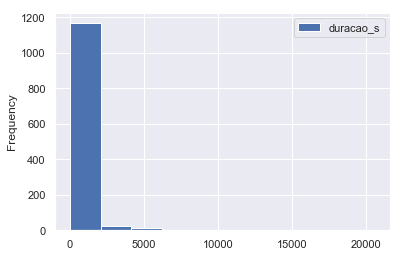

In [27]:
sub_table[['duracao_s']].plot.hist()

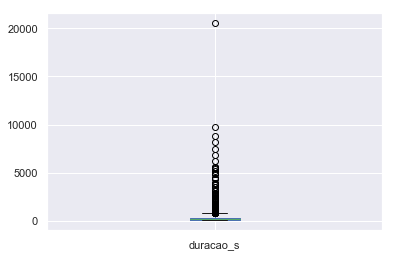

In [28]:
sub_table[['duracao_s']].plot.box()

## Analisando relação entre as ocorrências

In [68]:
# Carregar dados em um dicionario
dados = table.iloc[:].values

In [70]:
dict_ocorrencia = {} # o dicionario armazena, para cada ocorrência, a lista de ocorrências que ocorreram no intervalo de 1 hora
for i in range(len(dados)):
    horario_limite = (dados[i][2])+pd.Timedelta(hours=1)
    lista_ocorrencias = []
    for j in range(i+1, len(dados)):
        if (dados[j][2] <= horario_limite and dados[j][1] == dados[i][1]):
            lista_ocorrencias.append([j, dados[j][5]])
        else:
            break
    dict_ocorrencia[(i, dados[i][5])] = lista_ocorrencias  # tupla (id_ocorrencia, lista de ocorrências)

In [71]:
def buscar_ocorrencias(name_encoded, dicionario): 
    chaves = dicionario.keys()
    chaves_ocorrencias = []
    for i in range(len(dicionario)):
        if ((i, name_encoded) in chaves):
            key = (i, name_encoded)
            chaves_ocorrencias.append(key)
    return chaves_ocorrencias # dado o código de um evento é retornado o(s) id(s) da(s) ocorrências que aquele evento ocorreu

import collections

def listar_ocorrencias(chaves, dicionario):
    ocorrencias = []
    for chave in chaves:
        for i in range(len(dicionario[chave])):
            ocorrencias.append(str(dicionario[chave][i][1]))
    return collections.Counter(ocorrencias) # os eventos são organizados em uma coleção

def gerar_grafico(coll_ocorrencias, n_ocorrencias):
    mais_comum = dict(coll_ocorrencias.most_common(n_ocorrencias))
    
    import matplotlib.pyplot as plt
    ocorr = list(mais_comum.keys())
    qtd_ocorr = list(mais_comum.values())

    plt.bar(ocorr, qtd_ocorr, color='red')
    plt.xticks(ocorr)
    plt.ylabel('qtd de ocorrências')
    plt.xlabel('cod. ocorrência')
    plt.rcParams['figure.figsize'] = (30,10)
    plt.show()

In [72]:
def run_analise_relacao(dicionario, cod_ocorrencia, n_ocorrencias):
    keys = buscar_ocorrencias(cod_ocorrencia, dicionario)
    c = listar_ocorrencias(keys, dicionario)
    gerar_grafico(c, n_ocorrencias)

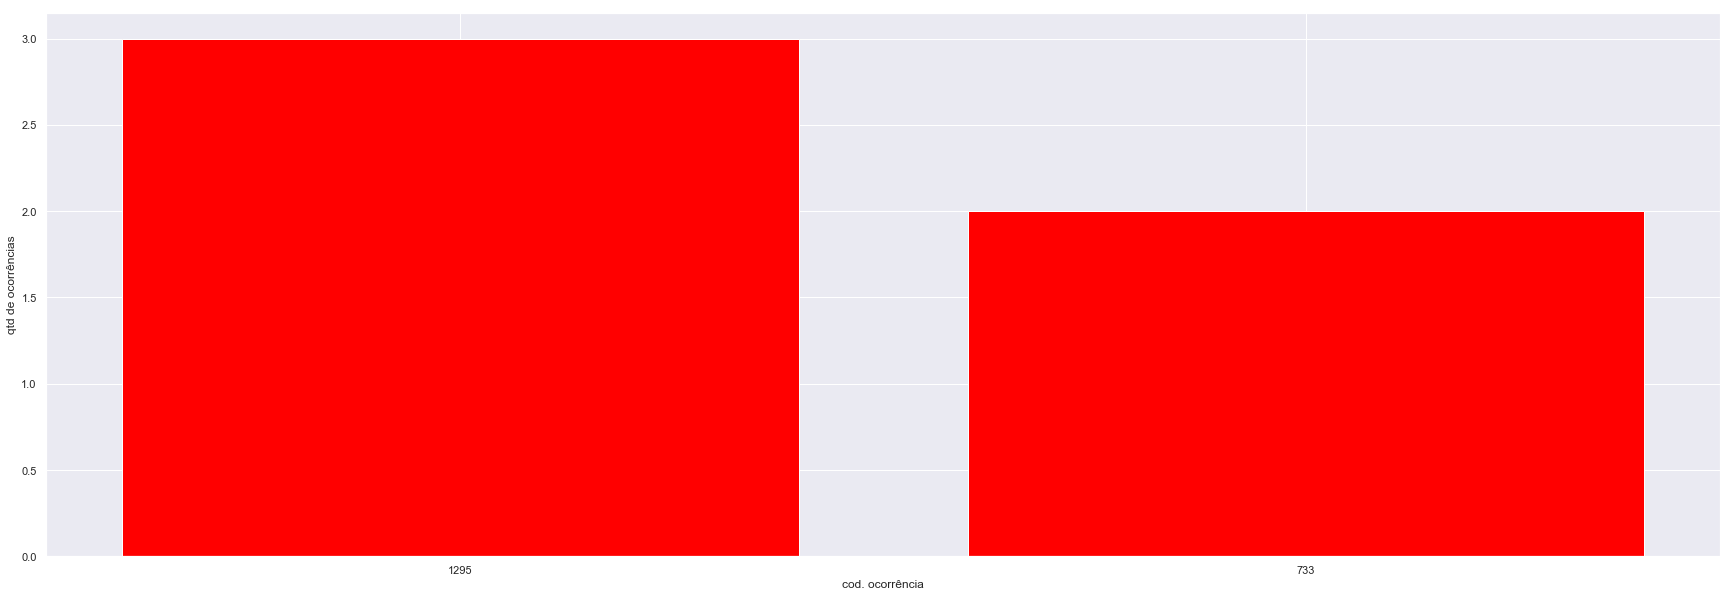

In [78]:
# dados - em formato de dicionario c/ todas as ocorrências
# cod_evento
# qtd de eventos relacionados


# o gráfico vai mostrar para dado um evento quais os n eventos que mais ocorreram

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (30,10)
run_analise_relacao(dict_ocorrencia, 732, 25)

In [79]:
# pra saber o nome do evento
print(lbe.classes_[732])
print(lbe.classes_[1295])
print(lbe.classes_[733])

Backup em MTF-mtz-cad está rodando
Falha - Backup em MTF-mtz-cad com problema - Fatal
Backup em MTF-mtz-cad solicitando mount
